In [1]:
%matplotlib inline

import os
import pickle
import matplotlib.colors as colors

import matplotlib.pyplot as plt

import matplotlib

import numpy as np

from matplotlib.colors import ListedColormap

import matplotlib.patches as patches

import h5py

### general style/labels used throughout the notebook

In [2]:
# Figure sizes e.g., Physics of Plasmas figure sizes
OneColWidth = 3.37
TwoColWidth = 6.69

# label for the different simulations (e.g., used in figure legends)
# the ID (i.e., the key of the dict) must be the subfolder name where the analysis data is located
# e.g., if the simulations are in  '/work/05181/pgrete/stampede2/TG/MS0.1' set key to MS0.1 and
# the other part as RootDir variable (see 4 cells belows)
IdLabels = {
    'Ms0.1-128' : r'Ms = 0.1 - $128^3$',
}


In [3]:
def createSimDict(firstId,lastId,AnaRess,dt):
    return {
        # first and last snapshot to be read (will assume increments of 1 between snapshot ids)
        "firstId": firstId,        
        "lastId": lastId,
        # resolution which as used for the analysis
        "AnaRess" : AnaRess,
        # the proper time (i.e., in dynamical times) between individual snapshots
        "dt" : dt,
    }

### NOTE: the following three lines need to be changed/updated to reflect local data and parameters

In [4]:
# 
Simulations = {
    # ID (same as above) other parameters, see ell above
    'Ms0.1-128' : createSimDict(1,32,[128],0.6283),    
}

In [5]:
Ids = list(Simulations.keys())

In [6]:
# the folder that contains all simulations (in subfolders)
RootDir = '/work/05181/pgrete/stampede2/TG/'

# Read statistics 

In [7]:
FlowStats = {}

In [8]:


#Ids = Simulations.keys()

for Id in Ids:
    
    FlowStats[Id] = {}
        
    for AnaRes in Simulations[Id]["AnaRess"]:
        
        FlowStats[Id][AnaRes] = {}
        readFiles = 0         
        
        for Dump in np.arange(Simulations[Id]["firstId"],
                              Simulations[Id]["lastId"]+1):
        
            Dir = RootDir + Id

            
            File = Dir + "/" + str(Dump).zfill(5) +  "-stats-" + str(AnaRes) + ".hdf5"
            if not os.path.isfile(File):
                print("missing " + File)
                continue

            FlowStats[Id][AnaRes][Dump] = {}
            
            try:
                flowquant = h5py.File(File,"r")

                FlowStats[Id][AnaRes][Dump] = flowquant                

                readFiles += 1

            except:                    
                del FlowStats[Id][AnaRes][Dump]
                print("bad file " + File)

                
        print("Got %d flowQuants for %s at res %d" % (readFiles,Id,AnaRes))


Got 32 flowQuants for Ms0.1-128 at res 128


# Temporal evolutions

In [9]:
def plotEvol(Ids):
    fig,p = plt.subplots(5,1,figsize=(OneColWidth,6),sharex=True)

    for Id in Ids:
        AnaRes = Simulations[Id]["AnaRess"][0]


        for i, Quan in enumerate([('Ms' + '/moments/' + 'rms','RMS $\mathrm{Ms}$',True),
                                  ('Ms' + '/moments/' + 'mean','Mean $\mathrm{Ms}$',True),
                                  ('KinEnDensity' + '/moments/' + 'mean',r'Mean $\mathrm{Ekin}$',True),
                                  ('AbsDivU' + '/moments/' + 'mean',r'Mean $|\nabla \cdot \mathbf{u}|$',True),
                                  ('AbsRotU' + '/moments/' + 'mean',r'Mean  $|\nabla \times \mathbf{u}|$',True),
                                 ]):

                
                QuanName = Quan[0]
                Label = Quan[1]
                Lin = Quan[2]
                
                addEvolToAxis(p[i],Id,AnaRes,QuanName)
                p[i].set_ylabel(Label)
                #p[i].axvspan(3.,5.,color='gray',alpha=0.1)
                if not Lin:
                    p[i].set_yscale('log')
                p[i].grid()
                #p[i].set_xlim(0.,5.)
        

    p[0].legend(ncol=3,loc="lower left",bbox_to_anchor=(-0.2,1.))
    p[-1].set_xlabel('time $t$ [$T$]')
    
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.01,hspace=0.00)


In [10]:
def addEvolToAxis(p,Id,AnaRes,QuanName):
    tmpY = []
    tmpX =[]
    for Dump in sorted(FlowStats[Id][AnaRes].keys()):
        if Dump == 0:
            continue
        try:
            tmpY.append(FlowStats[Id][AnaRes][Dump][QuanName])
            tmpX.append(float(Dump)*Simulations[Id]['dt'])
        except Exception as e:
            print(e)
            print(Id,AnaRes,Dump,QuanName)
            pass
       

    p.plot(tmpX,tmpY,label=IdLabels[Id])
    

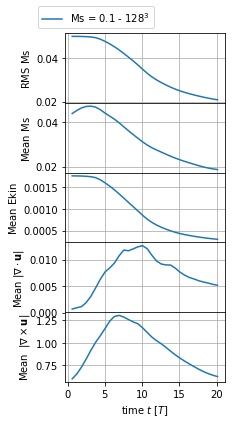

In [11]:
plotEvol(Ids)

# Spectra

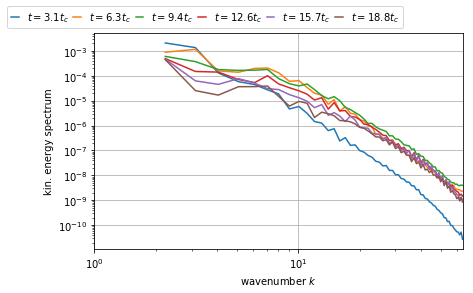

In [12]:
fig, p = plt.subplots(1,1,figsize=(TwoColWidth,TwoColWidth/1.6),sharex=True)

Type = 'Full'
Quan = 'rhoU'

for Id in Ids:

    for Dump in [5,10,15,20,25,30]:
        AnaRes = Simulations[Id]["AnaRess"][0]        

        X = FlowStats[Id][AnaRes][Dump][Quan + '/PowSpec/'+Type][0][1:]
        Y = FlowStats[Id][AnaRes][Dump][Quan + '/PowSpec/'+Type][1][1:]

        mask = np.logical_and(X < AnaRes/2,X != 0.)

        #Style = 
        p.plot(X[mask],Y[mask],
                  label="$t = %.1f t_c$" % (Dump * Simulations[Id]["dt"]) 
                 )

p.set_xlim(1.,AnaRes/2)
p.set_xscale("log")
p.set_yscale("log")

p.set_ylabel("kin. energy spectrum")
p.set_xlabel("wavenumber $k$")

p.legend(loc="lower left",ncol=8,
            handlelength=0.75,
            columnspacing=0.5,
            #fontsize=8,
            bbox_to_anchor=(-0.25,1.))

p.grid()

fig.tight_layout()
fig.subplots_adjust(wspace=0.05,hspace=0.00)

# Histograms

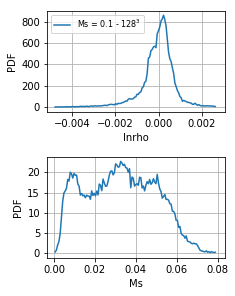

In [13]:
#HistBins = 'globalMinMax'
HistBins = 'Snap'
def getMeanHist(Id,AnaRes,Quan):
    tmp = []    
    for Dump in FlowStats[Id][AnaRes].keys():
        if Dump != 15:
            continue
        X = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][0]
        Vals = FlowStats[Id][AnaRes][Dump][Quan + '/hist/' + HistBins + 'MinMax'][1]                
        TotSum = np.sum((X[1]-X[0])*Vals)
            
        tmp.append(Vals/TotSum)
    return (X,
            np.mean(tmp,axis=0), np.std(tmp,axis=0))
        
Quans = [#'Angle_u_a',
         'lnrho',
            'Ms',
         #'LOSB_x',
         #'LOSB_y',
         #'LOSB_z',
        ]
NumRows = len(Quans)

fig, p = plt.subplots(NumRows,1,figsize=(OneColWidth,OneColWidth/1.6*NumRows))
if NumRows == 1:
    p = [p]
for i, Quan in enumerate(Quans):
    for Id in Ids:
        
        X,Y,YStd = getMeanHist(Id,AnaRes,Quan)
        
        
        p[i].plot(X[:-1],Y[:-1],label=IdLabels[Id])
        #p[1].plot(X,Y,label=IdLabels[Id])
        #print(YStd)
        p[i].fill_between(X,
                          Y - YStd,
                          Y + YStd,
                         alpha=0.3)        

    p[i].set_ylabel('PDF')
    p[i].set_xlabel(Quan)

for i in range(NumRows):
    p[i].grid()



#p[1].set_yscale('log')    
p[0].legend(loc='upper left',bbox_to_anchor=(0.,1.),ncol=3,fontsize=8)
#p[1].set_xlim(-0.75,0.5)
fig.tight_layout()

